## Sentence Quality Classification

Classifiy sentences into high / low quality. This is used to improve data quality for texts from different sources (scanned PDFs, crawled HTML, parsed Wikipedia, ..). It's mainly used to filter out artifacts from faulty parsing, HTML fragments, navigation elements, non-sentences (references, titles, ..)

This notebook uses BERT for this task. Other approaches can be found in sentence_quality_classifier.ipynb

In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import load_config
import json
import numpy as np

### define a new configuration
config_dict = {
    # training data
    "train_file": "data/sentence-quality-8k.csv",
    "seq_len": 128,
    "batch_size": 128,
    "epochs": 5,
    "lr": 1e-4,
    
    # where to store the configuration file
    "config_path": "data/configuration-sentence-quality-classifier-bert.json"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
### save config file (don't change)
config_src = config_dict["config_path"]

with open(config_src, 'w+') as f:
    json.dump(config_dict, f, indent=4)
    
# load config object based on config file (don't change)
config = load_config.Configuration(config_src, True)

In [3]:
# load training data
import pandas as pd 

data = pd.read_csv(config['train_file']) 
data = data.sample(frac=1).reset_index(drop=True)

Number of sentences: 8005
Number of sentences with label: 8005


,Satz,Tokens,Klassierung,Bemerkungen,label
0,"und im Jahre 1994 der Weltverband ""Internation...","['und', 'im', 'jahre', '1994', 'der', 'weltver...",LOW_QUALITY,NaN,LOW_QUALITY
1,Das Schrittmachersyndrom ist eine Bezeichnun...,"['das', 'schrittmachersyndrom', 'ist', 'eine',...",SENTENCE,NaN,SENTENCE
2,"Versorgungsstrukturen in der Psychiatrie €hne,...","['versorgungsstrukturen', 'in', 'der', 'psychi...",LOW_QUALITY,NaN,LOW_QUALITY
3,KG Heidelberg SmithKline Beecham GmbH & Co.,"['kg', 'heidelberg', 'smithkline', 'beecham', ...",REFERENCE,NaN,REFERENCE
4,Medizinischen Klinik und Poliklinik der Univer...,"['medizinischen', 'klinik', 'und', 'poliklinik...",LOW_QUALITY,NaN,LOW_QUALITY


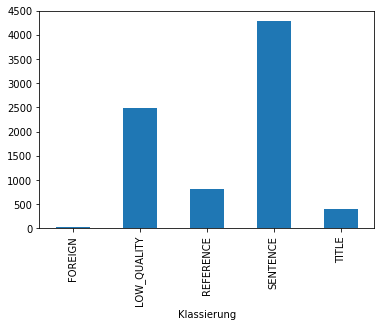

In [6]:
# set targets
print("Number of sentences: " + str(len(data.index)))
data = data.dropna(subset= ['Klassierung'])
print("Number of sentences with label: " + str(len(data.index)))
data.groupby('Klassierung').Klassierung.count().plot.bar()

#data['label'] = pd.Series(['high' if a else 'low' for a in data['Klassierung'].isin(['SENTENCE'])], index=data.index)
data['label'] = pd.Series(data['Klassierung'], index=data.index)

# set label / classes
classes = list(data['label'].unique())
data.head()

In [19]:
# Load BERT model
from keras_bert import Tokenizer
import keras
from keras_bert import get_base_dict, get_model, gen_batch_inputs
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths
import codecs
from keras_bert import load_trained_model_from_checkpoint

model_path = get_pretrained(PretrainedList.multi_cased_base)
paths = get_checkpoint_paths(model_path)
print(paths.config, paths.checkpoint, paths.vocab)

token_dict = get_base_dict()  # A dict that contains some special tokens
with codecs.open(paths.vocab, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)
        
print("Vocabulary size: " + str(len(token_dict)))

model = load_trained_model_from_checkpoint(
    paths.config,
    paths.checkpoint,
    training=True,
    trainable=True,
    seq_len=config["seq_len"],
)

/home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_config.json /home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/bert_model.ckpt /home/tim/.keras/datasets/multi_cased_L-12_H-768_A-12/vocab.txt
Vocabulary size: 119548


In [27]:
tokenizer = Tokenizer(token_dict)
tokenizer.tokenize(data["Satz"][234])

indices = []
for sentence in data["Satz"]:
    ids, segments = tokenizer.encode(sentence, max_len=config["seq_len"])
    indices.append(ids)

indices = np.array(indices)

print(indices.shape)
print(indices[2])

from sklearn.model_selection import train_test_split
# X_train, X_test, char_int_encoded_train, char_int_encoded_test, y_train, y_test = train_test_split(np.array([e[0] for e in data['input']]), char_int_encoded, data['label'], random_state = 2)

(8005, 128)
[   105  15943 103305  34877  89437  10137  10107  10119  97765  14951
  27826  12905   1776  37894    118  18644  79847  10207  81970  10166
    118    171    120  10806  14511  12351    118  12212  42042    190
    120  12604    118  77587  57554  10731  18290  10124    118  11736
  10114  75981 102697  10163  46961  60261    118  28781  16823  14404
    176    120  29957  13865  10162    119  42940    118  17256  53505
  10404  86982  10108  20924  10163    118  77587  57554  10348  19154
  10131    192    120  39313  50938  10107  27016    123    123    120
    123    123    120    124    123    120    125  46504 110535  10113
    120    105      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0]
